In [1]:
import numpy as np
import pandas as pd
from numpy import array
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#process data

#read from csv
df=pd.read_csv('data/multivariate/kenya_all_indicators.csv')
xlabel = 'Year'
y1label = 'Heath Expenditure (%GDP)' 
y2label = 'Birth Rate (per 1000 people)'
title = 'Health Expenditure vs Birth Rate'

df.head(10)


,year,he,brt,infant,u5
0,2000,4.639261,40.037,28.5,98.5
1,2001,4.803683,39.777,28.4,94.2
2,2002,4.958624,39.468,28.1,89.9
3,2003,5.169111,39.135,27.9,85.5
4,2004,5.344938,38.773,27.5,81.1
5,2005,5.314368,38.366,27.1,76.5
6,2006,5.873446,37.890,26.5,72.3
7,2007,5.997070,37.330,26.0,68.3
8,2008,6.049857,36.678,25.5,63.9
9,2009,6.027808,35.942,24.9,60.3


Text(0.5, 0.98, 'Health Expenditure vs Birth Rate')

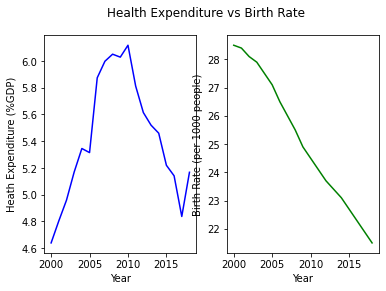

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(df['year'],df['he'], color = 'blue')
ax2.plot(df['year'],df['infant'], color = 'green')
ax1.set(xlabel = xlabel,ylabel = y1label)
ax2.set(xlabel = xlabel,ylabel = y2label)
fig.suptitle(title)


In [41]:
#separate data into training and test datasets as arrays
training_set = df.iloc[:13, 1:4].values
test_set = df.iloc[13:, 1:4].values
test_years=df.loc[15:, 'year'].values
test_years = np.reshape(test_years, (4,1))

#normalize the data? not added yet.....
scaler = MinMaxScaler(feature_range = (0,1))
scaled_train_samples = scaler.fit_transform(training_set)

#timesteps
n_steps = 3

#features
n_features = 2
training_set

array([[ 4.63926125, 40.037     , 28.5       ],
       [ 4.8036828 , 39.777     , 28.4       ],
       [ 4.95862436, 39.468     , 28.1       ],
       [ 5.16911125, 39.135     , 27.9       ],
       [ 5.3449378 , 38.773     , 27.5       ],
       [ 5.31436777, 38.366     , 27.1       ],
       [ 5.87344599, 37.89      , 26.5       ],
       [ 5.99706984, 37.33      , 26.        ],
       [ 6.04985666, 36.678     , 25.5       ],
       [ 6.02780771, 35.942     , 24.9       ],
       [ 6.11675072, 35.128     , 24.5       ],
       [ 5.81170416, 34.249     , 24.1       ],
       [ 5.61369753, 33.333     , 23.7       ]])

In [42]:
#split the data set into time steps that predict the next step: x for samples, y for labels (actual output)

def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix-1, -1]
        x.append(seq_x)
        y.append(seq_y)
    return array(x), array(y)

#prepare the data for training
x, y = split_sequence(training_set, n_steps)
x

array([[[ 4.63926125, 40.037     ],
        [ 4.8036828 , 39.777     ],
        [ 4.95862436, 39.468     ]],

       [[ 4.8036828 , 39.777     ],
        [ 4.95862436, 39.468     ],
        [ 5.16911125, 39.135     ]],

       [[ 4.95862436, 39.468     ],
        [ 5.16911125, 39.135     ],
        [ 5.3449378 , 38.773     ]],

       [[ 5.16911125, 39.135     ],
        [ 5.3449378 , 38.773     ],
        [ 5.31436777, 38.366     ]],

       [[ 5.3449378 , 38.773     ],
        [ 5.31436777, 38.366     ],
        [ 5.87344599, 37.89      ]],

       [[ 5.31436777, 38.366     ],
        [ 5.87344599, 37.89      ],
        [ 5.99706984, 37.33      ]],

       [[ 5.87344599, 37.89      ],
        [ 5.99706984, 37.33      ],
        [ 6.04985666, 36.678     ]],

       [[ 5.99706984, 37.33      ],
        [ 6.04985666, 36.678     ],
        [ 6.02780771, 35.942     ]],

       [[ 6.04985666, 36.678     ],
        [ 6.02780771, 35.942     ],
        [ 6.11675072, 35.128     ]],

       [[ 

In [43]:
#build the model
#activation: relu to get the max btwn 0 and the input, default activation on the output layer (sigmoid), Dense on output

model = Sequential([
    LSTM(units=50, input_shape=(n_steps, n_features), activation='relu',return_sequences=True),
    LSTM(50, activation='relu',return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(units=1)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 3, 50)             10600     
_________________________________________________________________
lstm_7 (LSTM)                (None, 3, 50)             20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 51,051
Trainable params: 51,051
Non-trainable params: 0
_________________________________________________________________


In [44]:
#compile the model
model.compile(
    optimizer=Adam(learning_rate=0.01), 
    loss='mse', 
    metrics=['accuracy']
)
#train the model
model.fit(
    x, 
    y, 
    batch_size=1, 
    validation_split=0.1,
    epochs=100, 
    verbose=2
)

Epoch 1/100
9/9 - 2s - loss: 268.7085 - accuracy: 0.0000e+00 - val_loss: 13.0682 - val_accuracy: 0.0000e+00
Epoch 2/100
9/9 - 0s - loss: 8.0961 - accuracy: 0.0000e+00 - val_loss: 11.6735 - val_accuracy: 0.0000e+00
Epoch 3/100
9/9 - 0s - loss: 4.4771 - accuracy: 0.0000e+00 - val_loss: 3.0200 - val_accuracy: 0.0000e+00
Epoch 4/100
9/9 - 0s - loss: 1.5032 - accuracy: 0.0000e+00 - val_loss: 0.0577 - val_accuracy: 0.0000e+00
Epoch 5/100
9/9 - 0s - loss: 0.6913 - accuracy: 0.0000e+00 - val_loss: 0.0280 - val_accuracy: 0.0000e+00
Epoch 6/100
9/9 - 0s - loss: 0.5639 - accuracy: 0.0000e+00 - val_loss: 0.2765 - val_accuracy: 0.0000e+00
Epoch 7/100
9/9 - 0s - loss: 1.3034 - accuracy: 0.0000e+00 - val_loss: 2.4195 - val_accuracy: 0.0000e+00
Epoch 8/100
9/9 - 0s - loss: 4.0987 - accuracy: 0.0000e+00 - val_loss: 6.1046 - val_accuracy: 0.0000e+00
Epoch 9/100
9/9 - 0s - loss: 3.3012 - accuracy: 0.0000e+00 - val_loss: 1.3933 - val_accuracy: 0.0000e+00
Epoch 10/100
9/9 - 0s - loss: 1.5411 - accuracy: 0.

In [8]:
#Prep the test data
x_test, y_test = split_sequence(test_set, n_steps)

#Predict
predictions = model.predict(
    x_test,
    batch_size = 1, 
    verbose = 2
)
predictions

4/4 - 0s


array([[20.489985],
       [19.797985],
       [19.20515 ],
       [18.64771 ]], dtype=float32)

In [9]:
test_set

array([[ 5.51942348, 32.415     , 23.4       ],
       [ 5.45934105, 31.522     , 23.1       ],
       [ 5.21938848, 30.688     , 22.7       ],
       [ 5.14090538, 29.943     , 22.3       ],
       [ 4.8369956 , 29.296     , 21.9       ],
       [ 5.16729498, 28.748     , 21.5       ]])

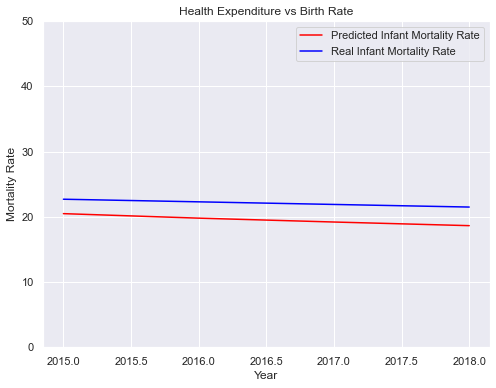

In [47]:
# Visualising the results

plt.plot(test_years,predictions, color = 'red', label = 'Predicted Infant Mortality Rate')
plt.plot(test_years,y_test, color = 'blue', label = 'Real Infant Mortality Rate')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Mortality Rate')
plt.title(title)
plt.ylim(0, 50) #used to fit the graph to give a better visual 
plt.show()
sns.set(rc={'figure.figsize':(8,6)})

            -------------Counterfactual Analysis using Dice-------------

In [12]:
import dice_ml


In [23]:
# supress deprecation warnings from TF
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

backend = 'TF'+tf.__version__[0]  # TF1

In [37]:
# Step 1: dice_ml.Data
training_set = df.iloc[:13, 1:4]
d = dice_ml.Data(dataframe=training_set, continuous_features=['he'], outcome_name='brt')

In [45]:
# Step 2: dice_ml.Model
m = dice_ml.Model(model_path=model, backend=backend)

In [46]:
# Step 3: initiate DiCE
exp = dice_ml.Dice(d, m)

TypeError: expected str, bytes or os.PathLike object, not Sequential